In [49]:
! pip install keras
! pip install tensorflow

^C
ERROR: Operation cancelled by user
     |████████████████████████████████| 421.8 MB 16 kB/s s eta 0:00:01MB 10.5 MB/s eta 0:00:36     |█████████                       | 119.4 MB 93.5 MB/s eta 0:00:04     |█████████████                   | 170.9 MB 93.5 MB/s eta 0:00:03
     |████████████████████████████████| 2.7 MB 62.0 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 546 kB/s  eta 0:00:01
     |████████████████████████████████| 63 kB 174 kB/s  eta 0:00:01
     |████████████████████████████████| 3.8 MB 49.8 MB/s eta 0:00:01
     |████████████████████████████████| 104 kB 49.9 MB/s eta 0:00:01
     |████████████████████████████████| 26.1 MB 63.1 MB/s eta 0:00:01
     |████████████████████████████████| 448 kB 47.7 MB/s eta 0:00:01
     |████████████████████████████████| 88 kB 410 kB/s  eta 0:00:01
     |████████████████████████████████| 76 kB 441 kB/s  eta 0:00:01
     |████████████████████████████████| 298 kB 26.5 MB/s eta 0:00:01
     |████████████████████████████████| 

In [19]:
# read the csv
import os
data_dir = 'jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [20]:
# convert to numpy array
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

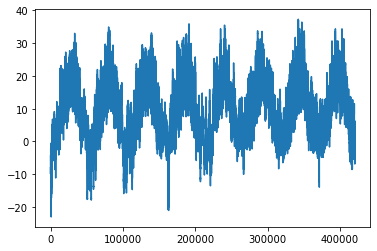

In [21]:
# plot the temprature
from matplotlib import pyplot as plt

temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)

In [22]:
# normalize the data
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [38]:
# define a genrator that will supply data

def generator(data, lookback, delay, min_index, max_index, 
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay -1
    i = min_index + lookback
    while True:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size
            )
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(
                i, min(i + batch_size, max_index)
            )
            i += len(rows)
            
        samples = np.zeros((len(rows),
                           lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows), ))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets 

In [39]:
# setting up the generators

lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=0,
                     max_index=200000,
                     shuffle=True,
                     step=step,
                     batch_size=batch_size)
val_gen = generator(float_data,
                   lookback=lookback,
                   delay=delay,
                   min_index=200001,
                   max_index=300000,
                   step=step,
                   batch_size=batch_size)
test_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=300001,
                    max_index=None,
                    step=step,
                    batch_size=batch_size)
val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data - 300001 - lookback)) // batch_size

In [45]:
# test out a naive method for temp prediction. the temp 24 hours from now will be 
# the temprature right now
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

evaluate_naive_method()
celsius_mae = 0.29 * std[1]
print(celsius_mae)

0.2897359729905486
2.5672247338393395


In [54]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=20,
                             validation_data=val_gen,
                             validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 15s 30ms/step - loss: 1.4331 - val_loss: 0.4849
Epoch 2/20
500/500 [==============================] - 15s 30ms/step - loss: 0.4452 - val_loss: 0.7114
Epoch 3/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2940 - val_loss: 0.4810
Epoch 4/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2679 - val_loss: 0.6257
Epoch 5/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2554 - val_loss: 0.5160
Epoch 6/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2466 - val_loss: 0.6338
Epoch 7/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2384 - val_loss: 0.2674
Epoch 8/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2320 - val_loss: 0.4467
Epoch 9/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2277 - val_loss: 0.3999
Epoch 10/20
500/500 [==============================] - 15s 30ms/step - loss: 0.222

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()